## Περιεχόμενα

- Eφαρμογή Searches στο χώρο των υπερπαραμέτρων διάφορων μοντέλων χρησιμοποιώντας 7 υποσύνολα των χαρακτηριστικών:
    - Grid Search για την εύρεση βέλτιστων υπερπαραμέτρων του Random Forest Classifier
    - Bayesian Search για την εύρεση βέλτιστων υπερπαραμέτρων του AdaBoost Classifier με base estimator Decision Tree 
    - Bayesian Search για την εύρεση βέλτιστων υπερπαραμέτρων του AdaBoost Classifier με base estimator Linear Regressor
    - Bayesian Search για την εύρεση βέλτιστων υπερπαραμέτρων του Gradient Boosting Classifier
- Ανάλυση της κατεύθυνσης των βέλτιστων υπερπαραμέτρων με την συνάρτηση `plot_yerr`
- Ανάλυση των στατιστικών του καλύτερου μοντέλου κάθε υποσυνόλου χαρακτηριστικών για δεδομένο Classifier με τη συνάρτηση `get_stats_dict`
- Ανάλυση του confusion matrix του καλύτερου μοντέλου και υποσυνόλου για δεδομένο Classifier

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier)

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector as SFS

from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     StratifiedKFold)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

import pickle

In [2]:
# Για να φαίνεται κάθε column του dataframe με τα στατιστικά
# το οποίο δημιουργείται με τη συνάρτηση get_stats_dict
pd.set_option('display.max_columns', 23)

In [3]:
def plot_yerr(grid_search, parameters, n_rows=2):
    '''
    Συνάρτηση για να παράγει yerr διαγράμματα των παραμέτρων ως προς το test score.
    
    Λειτουργεί καλύτερα με grid_search όπου ίδια τιμή μιας υπερπαραμέτρου επιλέγεται 
    πολλαπλές φορές.
    Μπορεί να χρησιμοποιηθεί και με bayesian καθώς από cross validation, προκύπτει 
    μέση τιμή και διακύμανση (std) του test score
    '''
    
    
    # Εξαγωγή των κατάλληλων columns από τα αποτελέσματα του grid search
    results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
        
    fig, axes = plt.subplots(n_rows, 3, figsize=(12, 4*n_rows))
    axes = axes.flatten()  # Flatten για ευκολότερο indexing

    for i, parameter in enumerate(parameters):
        # Δημιουργία columns με κάθε ένα από τους parameter
        # Τα rows του results['params'] είναι λεξικά ['parameter': value]
        results[parameter] = results['params'].apply(lambda x: x[parameter]) # για κάθε λεξικό x,
                                                                             # πάρε το value του key = parameter 
        
        results.set_index(parameter, inplace=True)

        # Group by parameter και υπολογισυμός του μέσου mean_test_score και μέσου std_test_score
        y = results.groupby(parameter)['mean_test_score'].mean().reset_index()
        x = y[parameter]
        err = results.groupby(parameter)['std_test_score'].mean().reset_index()

        # errobar plot
        axes[i].errorbar(x, y['mean_test_score'], yerr=err['std_test_score'], fmt='-o')
        axes[i].set_title(f'{parameter} vs Mean Test Score')
        axes[i].set_xlabel(parameter)
        axes[i].set_ylabel('Mean Test Score')

    for j in range(i + 1, len(axes)): # Σε περίπτωση που δεν γεμίσουν τα plots, διαγράφει τα υπόλοιπα κενά διαγράμματα
        axes[j].axis('off')

        
    # καλύτερο spacing
    plt.tight_layout()
    plt.show()

In [4]:
def get_best_params(grid_search):
    '''
    Χρησιμοποιείται στη συνάρτηση get_stats_dict()
    
    Επιστρέφει τις καλύτερες υπερπαραμέτρους για 
    δεδομένο Grid/Bayesian search
    '''
    
    cv_results = grid_search.cv_results_
    
    # index του καλύτερου mean_test_score
    best_test_score_index = cv_results['mean_test_score'].argmax()

    # Παίρνει τις υπερπαραμέτρους με το καλύτερο mean_test_score
    best_params = cv_results['params'][best_test_score_index]
    
    return best_params

In [5]:
def calc_sens_spec(conf_matrix):
    '''
    Χρησιμοποιείται στη συνάρτηση get_stats_dict()
    
    Επιστρέφει 2 λεξικά, το sensitivity κάθε κλάσης
    και το specificity κάθε κλάσης για δεδομένο classifier
    (από grid ή bayesian search)
    '''
    
    num_classes = conf_matrix.shape[0]
    
    tp = np.diagonal(conf_matrix)  # True Positives 
    fn = np.sum(conf_matrix, axis=0) - tp  # False Negatives 
    fp = np.sum(conf_matrix, axis=1) - tp  # False Positives
    tn = np.array([np.sum(conf_matrix) - (tp[i] + fn[i] + fp[i]) for i in range(num_classes)])  # True Negatives
    
    sensitivity = tp/(tp+fn) # δεδομένου ότι ανήκει στη κλάση x, ποία είναι η πιθανότητα το μοντέλο να προβλέψει κλάση x
    specificity = tn/(tn+fp) # δεδομένου ότι δεν ανήκει στη κλάση x, ποία είναι η πιθανότητα το μοντέλο να μην προβλέψει κλάση x
    
    dict_sensitivity= {}
    dict_specificity= {}
    
    for i in range(len(sensitivity)):
        dict_sensitivity[f"sens c_{i}"] = sensitivity[i]
        dict_specificity[f"spec c_{i}"] = specificity[i]
        
    return dict_sensitivity, dict_specificity

In [6]:
def get_stats_dict(model_dict):
    '''
    Δημιουργεί λεξικό με best_mean_test_score_cv,
    final_test_score, spensitivity και specifity κάθε κλάσης
    και τις καλύτερες παραμέτρους
    
    Παίρνει λεξικό με key τα εκπαιδευμένα μοντέλα του search
    και values το (sub)set των χαρακτηριστικών.
    
    Επιστρέφει το λεξίκο
    '''
    
    stats_dict = {}
    
    for i in range(len(model_dict)):
        stats_dict[f'gs_{i}']  = {}

    for i, (model, param_set) in enumerate(model_dict.items()):

        stats_dict[f"gs_{i}"]["best_mean_test_score_cv"] = model.cv_results_['mean_test_score'].max()
        stats_dict[f"gs_{i}"]["final_test_score"] = model.score(X_test[param_set], y_test.squeeze())

        y_pred = model.predict(X_test[param_set])
        cm = confusion_matrix(y_test, y_pred)
        dict_sensitivity, dict_specificity = calc_sens_spec(cm)
        
        
        for key, value in dict_sensitivity.items():
            stats_dict[f"gs_{i}"][key] = value
            
        for key, value in dict_specificity.items():
            stats_dict[f"gs_{i}"][key] = value
        
        best_params = get_best_params(model)
        
        for key, value in best_params.items():
            stats_dict[f"gs_{i}"][key] = value

    return stats_dict

In [7]:
df = pd.read_csv("data_preprocessed.csv")

In [8]:
df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,Gender_Female,family_history_with_overweight_yes,FAVC_no,SMOKE_no,SCC_no,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,-0.522124,-0.875589,-0.862558,2.0,3.0,1,2.0,0.0,1.0,0,1,1,1,1,1,1,0,1
1,-0.522124,-1.947599,-1.168077,3.0,3.0,1,3.0,3.0,0.0,1,1,1,1,0,0,1,0,1
2,-0.206889,1.054029,-0.366090,2.0,3.0,1,2.0,2.0,1.0,2,0,1,1,1,1,1,0,1
3,0.423582,1.054029,0.015808,3.0,3.0,1,2.0,2.0,0.0,2,0,0,1,1,1,0,1,2
4,-0.364507,0.839627,0.122740,2.0,1.0,1,2.0,0.0,0.0,1,0,0,1,1,1,1,0,3


In [9]:
X = df.drop('NObeyesdad', axis=1)
y = df[['NObeyesdad']]

- Κατά τη διάρκεια της διαδικασίας Grid Search ή Bayesian Optimization για την επιλογή υπερπαραμέτρων, πραγματοποιείται cross-validation.
- Ωστόσο, διατηρείται και ένα ξεχωριστό test set. Αυτό γίνεται γιατί, αν και το cross-validation βοηθά στην επιλογή του μοντέλου με τις βέλτιστες υπερπαραμέτρους βάσει των επιδόσεων στο validation set, το μοντέλο που θα επιλεχθεί ενδέχεται να έχει υπερπαραμέτρους που προσαρμόζονται καλύτερα στο validation set και όχι απαραίτητα στο γενικότερο σύνολο των δεδομένων.
- Για το λόγο αυτό, το test set κρατείται ξεχωριστά, προκειμένου να εκτιμηθεί η πραγματική απόδοση του μοντέλου και η ικανότητά του να γενικεύει σε άγνωστα δεδομένα.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,
                            y,
                            test_size=0.2,
                            random_state=42,
                            stratify = y
                           )

In [11]:
X_train.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE',
       'CALC', 'Gender_Female', 'family_history_with_overweight_yes',
       'FAVC_no', 'SMOKE_no', 'SCC_no', 'MTRANS_Public_Transportation',
       'MTRANS_Walking'],
      dtype='object')

In [12]:
# όλα τα χαρακτηριστικά
feature_set_0 = list(X_train.columns)

# τα χαρακτηριστικά βάση mutual information με threshold mi > 0.2
feature_set_1 = ['Weight', 'Age', 'Height', 'Gender_Female']

# τα χαρακτηριστικά βάση mutual information με threshold mi > 0.1
feature_set_2 = feature_set_1[:]
feature_set_2.extend(['family_history_with_overweight_yes', 'CAEC', 'FCVC', 'NCP'])
 
# τα χαρακτηριστικά βάση cramers_v score με threshold cv > 0.3
feature_set_3 = ['Weight', 'Gender_Female', 'family_history_with_overweight_yes', 'FCVC', 'CAEC', 'Age', 'FAVC_no']

# τα χαρακτηριστικά βάση cramers_v score με threshold cv > 0.25
feature_set_4 = feature_set_3[:]
feature_set_4.extend(['CALC', 'NCP', 'MTRANS_Public_Transportation'])

# Τα δύο καλύτερα Χαρακτηριστικά βάση Embedded και Wrapper Methods
feature_set_5 = ['Height', 'Weight']

# Τα τρία καλύτερα Χαρακτηριστικά βάση Embedded και Wrapper Methods
feature_set_6 = ['Height', 'Weight', 'Age']

- Οι αλγόριθμοι Bagging (όπως ο Random Forest Classifier) είναι γενικά πιο γρήγορος λόγω της δυνατότητάς του για παραλληλισμό κατά την εκπαίδευση. Κάθε δέντρο του rfc εκπαιδεύεται ανεξάρτητα από τα υπόλοιπα, κάτι που επιτρέπει τη χρησιμοποίηση πολλών πυρήνων επεξεργασίας για ταυτόχρονη εκπαίδευση. Αυτό μειώνει σημαντικά το χρόνο εκπαίδευσης. Έτσι, για την αναζήτηση των βέλτιστων υπερπαραμέτρων, επιλέχθηκε η μέθοδος Grid Search, η οποία εξετάζει ενδελεχώς διάφορους συνδυασμούς υπερπαραμέτρων και επιλέγει εκείνους που παρέχουν την καλύτερη απόδοση του μοντέλου.
- Οι αλγόριθμοι Boosting (όπως οι AdaBoost και Gradient Boosting Classifiers) είναι γενικά πιο αργοί σε σύγκριση με τους Bagging, λόγω της σειριακής φύσης της εκπαίδευσής τους. Σε αυτούς τους αλγόριθμους, κάθε μοντέλο εκπαιδεύεται διαδοχικά, με το κάθε επόμενο μοντέλο να βασίζεται στα λάθη του προηγούμενου. Αυτή η διαδικασία βελτιώνει την απόδοση στο training set, αλλά απαιτεί σημαντικά περισσότερο χρόνο, ειδικά όταν ο αριθμός των μοντέλων ή η πολυπλοκότητα αυξάνονται. Έτσι, για την αναζήτηση των βέλτιστων υπερπαραμέτρων στους αλγόριθμους Boosting, χρησιμοποιήθηκε η μέθοδος Bayesian Optimization, η οποία είναι πιο αποδοτική από το Grid Search σε τέτοιες περιπτώσεις. Η Bayesian Optimization μειώνει τον αριθμό των απαιτούμενων αξιολογήσεων, εντοπίζοντας ταχύτερα τους συνδυασμούς υπερπαραμέτρων που βελτιστοποιούν την απόδοση του μοντέλου.

## Random Forest Classifier

### - **Το ακόλουθο κελί δεν χρειάζεται να τρέξει λόγω υπολογιστικού φόρτου**
### - Το εκπαιδευμένο σύνολο των grid search είναι αποθηκευμένο ως rf_dict.pkl και φορτώνεται στη συνέχεια

In [103]:
# Δημιουργεί splits τα οποία έχουν ίδιες αναλογίες των κατηγορι΄ων του target
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# hyperparameter space του Random Forest
param_grid_rf = {
     'n_estimators': [100, 300, 500],  # Αριθμός των trees (estimators)
     'max_depth': [None, 20, 40, 60],  # Μέγιστο βάθος κάθε δέντρου
     'criterion': ['gini', 'entropy'], # κριτήριο που καθορίζει το split κάθε δέντρου 
     'min_samples_split': [2, 5],      # Ο ελάχιστον αριθμός δεδομένων ενός κόμβου για να σχαστεί 
     'min_samples_leaf': [1, 2],       # Ο ελάχιστον αριθμός δεδομένων που μπορεί να έχει ένας νέος κόμβος, για να σχαστεί ο προηγούμενος κόμβος
     'max_features': ['sqrt', 'log2'], # Αριθμός των χαρακτηριστικών που λαμβάνονται υπόψιν κατά την αναζήτηση του καλύτερου split 
}

# Για επαναληψιμότητα
random_state=42

# Αρχικοποίηση των GridSearchCV, ένα για κάθε υποσύνολο χαρακτηριστικών
rf_gs_0 = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
rf_gs_1 = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
rf_gs_2 = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
rf_gs_3 = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
rf_gs_4 = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
rf_gs_5 = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
rf_gs_6 = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)

# Λεξικό με key τα στιγμιότυπα των GridSearchCV και values τα υποσύνολα των χαρακτηριστικών, για ευκολία εκπαίδευσης και χρήσης
rf_dict = {rf_gs_0: feature_set_0,
           rf_gs_1: feature_set_1,
           rf_gs_2: feature_set_2,
           rf_gs_3: feature_set_3,
           rf_gs_4: feature_set_4,
           rf_gs_5: feature_set_5,
           rf_gs_6: feature_set_6}

# Εκπαίδευση των μοντέλων χρησιμοποιώντας τα αντίστοιχα υποσύνολα των χαρακτηριστικών
%%time # Τοπικά χρειάστηκε περίπου 9.5 λεπτά
for rf_model, param_set in rf_dict.items():
    rf_model.fit(X_train[param_set], y_train.squeeze())

In [106]:
## Αποθήκευση του μοντέλου
# with open('rf_dict.pkl', 'wb') as f:
#      pickle.dump(rf_dict, f)

In [13]:
# Διάβασμα του λεξικού με τα εκπαιδευμένα στιγμιότυπα GridSearchCV
with open('rf_dict.pkl', 'rb') as f:
    rf_dict = pickle.load(f)

In [14]:
# Χρήση της συνάρτησης get_stats_dict, που δέχεται το προηγούμενο λεξικό
rf_stats_dict = get_stats_dict(rf_dict)
rf_stats_df = pd.DataFrame(rf_stats_dict).T
rf_stats_df

,best_mean_test_score_cv,final_test_score,sens c_0,sens c_1,sens c_2,sens c_3,sens c_4,sens c_5,sens c_6,spec c_0,spec c_1,spec c_2,spec c_3,spec c_4,spec c_5,spec c_6,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
gs_0,0.95498,0.93617,1.0,0.80303,0.859649,0.963636,0.971831,0.983051,0.984615,0.989276,0.985994,0.97541,0.986413,0.997159,0.994505,0.997207,entropy,20,sqrt,1,2,300
gs_1,0.968007,0.957447,0.962264,0.915254,0.929825,0.948276,0.958904,1.0,0.984615,0.991892,0.989011,0.986339,0.991781,1.0,0.994521,0.997207,entropy,None,sqrt,1,2,300
gs_2,0.954383,0.955083,1.0,0.863636,0.961538,0.948276,0.958904,0.983051,0.984615,0.989276,0.997199,0.978437,0.991781,1.0,0.994505,0.997207,entropy,None,log2,1,2,100
gs_3,0.88034,0.891253,0.959184,0.746032,0.833333,0.923077,0.871795,0.935484,0.984615,0.981283,0.969444,0.96477,0.973046,0.994203,0.99446,0.997207,entropy,None,sqrt,1,5,100
gs_4,0.906393,0.91253,1.0,0.776119,0.821429,0.896552,0.956522,0.966102,0.984615,0.986631,0.983146,0.967302,0.983562,0.988701,0.991758,0.997207,gini,20,sqrt,1,2,500
gs_5,0.965048,0.976359,1.0,0.920635,1.0,0.983051,1.0,0.966667,0.970149,0.989276,1.0,0.99455,1.0,0.994366,0.99449,1.0,entropy,None,sqrt,1,5,100
gs_6,0.963863,0.947991,0.942308,0.9,0.946429,0.931034,0.945946,1.0,0.969697,0.986523,0.988981,0.986376,0.989041,1.0,0.991803,0.997199,entropy,None,sqrt,1,2,500


- Καλύτερο μοντέλο και υποσύνολο χαρακτηριστικών
    - Το καλύτερο feature subset φαίνεται να είναι το feature set 5 το οποίο περιέχει μόνο τα χαρακτηριστικά `Height` και `Weight`, και το test accuracy του μοντέλου είναι **97.64%**.
    - Οι καλύτερες υπερπαράμετροι για αυτό το feature set είναι, `n_estimators`= 100, `max_depth` = None, `criterion` = 'entropy', `min_samples_split` = 5, `min_samples_leaf` = 2, `max_features` = sqrt 
    - Γενικά παρατηρείται αναμενόμενα ότι τα χαρακτηριστικά `Height` και `Weight` περιέχουν την περισσότερη πληροφορία, και παράλληλα το μοντέλο που επιλέχθηκε είναι σχετικά απλό
- Δυσκολότερες κατηγορίες `sensitivity` και `specificity`
    - Προβλέπει καλύτερα από τα υπόλοιπα μοντέλα την πιο δύσκολη κατηγορία (`normal weight`) με sensitivity 92.063%
    - Έχει επίσης το δεύτερο καλύτερο specificity στη κατηγορία `insuffiecient weight`
- Γενικότερα
    - Έχει το καλύτερο (ή ίδιο με το καλύτερο) sensitivity στις κατηγορίες 0, 1, 2, 3, 4
    - Έχει το καλύτερο (ή ίδιο με το καλύτερο) specificity στις κατηγορίες 1, 2, 3, 6

In [15]:
# οταν δεν τρέχει το κελί με το search, δεν υπάρχουν και τα μεμονομένα searches, π.χ. rf_gs_0
# Για τη χρήση των μοντέλων από τα searches, δημιουργείτε το παρακάτω λεξικό
# Για τη χρήση μοντέλου από τα search 0, καλείται ως rf_model[0], π.χ. rf_model[0].score(x,y)

rf_model = {}

for i, key in enumerate(rf_dict.keys()):
    rf_model[i] = key
    
rf_parameters = ['n_estimators', 'max_depth', 'criterion', 'min_samples_split', 'min_samples_leaf', 'max_features']

- Στη συνέχεια φαίνεται το μέσο σφάλμα και η διακύμανση του σφάσλματος για κάθε τιμή των υπερπαραμέτρων από το gridsearch
- Φαίνεται ότι δεν παρατηρείται ιδιαίτερη διακύμανση του σφάλματος με τις περισσότερες υπερπαραμέτρους στο search με το μικρότερο υποσύνολο χαρακτηριστικών

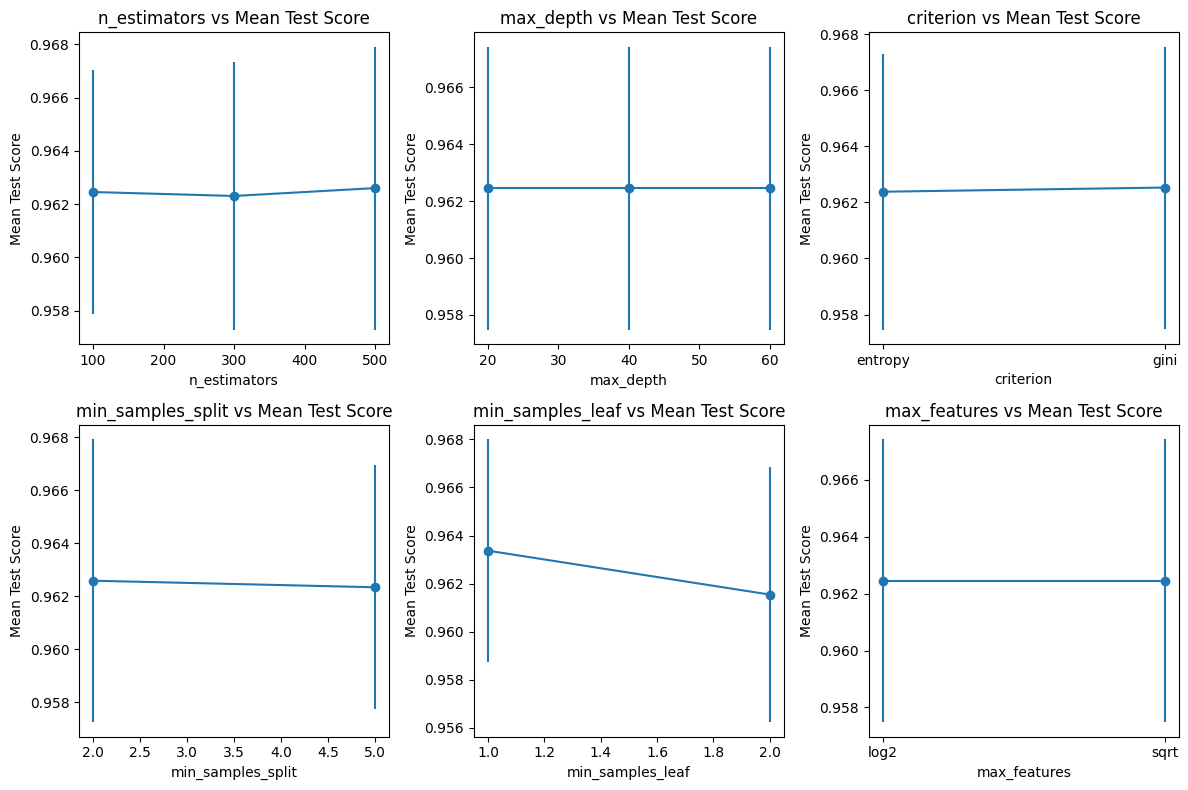

In [16]:
plot_yerr(rf_model[5], rf_parameters)

In [17]:
y_pred_rf = rf_model[5].predict(X_test[feature_set_5])
cm_rf = confusion_matrix(y_test, y_pred_rf)

- Το μοντέλο ταξινομεί σωστά τα 413 από τα 423 δεδομένα του test set 
- Παρατηρείται ισχυρή διαγώνιος
- 4/10 σφάλματα προέκυψαν με την πρόβλεψη κατηγορίας `Normal Weight`, ενώ η πραγματική κατηγορία είναι `Insufficient Weight`
- 9/10 σφάλματα προέρχονται από υπερεκτίμηση της αληθινής κατηγορίας κατά έναν βαθμό παχυσαρκίας

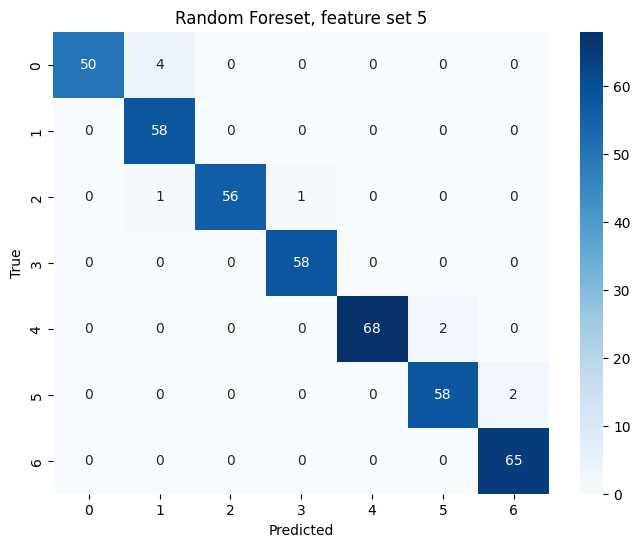

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.title('Random Foreset, feature set 5')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## AdaBoost Classifier (tree-based)

### - **Το ακόλουθο κελί δεν χρειάζεται να τρέξει λόγω υπολογιστικού φόρτου**
### - Το εκπαιδευμένο σύνολο των Bayesian search είναι αποθηκευμένο ως abtree_dict.pkl και φορτώνεται στη συνέχεια

In [114]:
# ίδια διαδικασία, αντί για Grid Search, γίνεται Bayesian Search από την skopts
# το hyperparameter space ορίζεται από την skopt.space (Real, Integer, Categorical)

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

base_estimator = DecisionTreeClassifier(random_state=42)

param_grid_ab = {
    'n_estimators': Integer(50, 1000), # αριθμός estimators
    'learning_rate': Real(0.001, 1, prior='log-uniform'), # Βάρος που εφαρμόζεται σε κάθε sub-clssifier σε κάθε επανάληψη boosting
    'algorithm': Categorical(['SAMME', 'SAMME.R']), # αλγόριθμος για την ενίσχυση των αδύναμων learner προς έναν ισχυρό enseble classifier
    'estimator__max_depth': Integer(1, 5),  
    'estimator__min_samples_split': Integer(2, 5), 
    'estimator__min_samples_leaf': Integer(1, 5), 
    'estimator__criterion': Categorical(['gini', 'entropy']),
}

random_state=42

abtree_gs_0 = BayesSearchCV(AdaBoostClassifier(estimator = base_estimator, random_state=random_state),
                            param_grid_ab, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
abtree_gs_1 = BayesSearchCV(AdaBoostClassifier(estimator = base_estimator, random_state=random_state),
                            param_grid_ab, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
abtree_gs_2 = BayesSearchCV(AdaBoostClassifier(estimator = base_estimator, random_state=random_state),
                            param_grid_ab, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
abtree_gs_3 = BayesSearchCV(AdaBoostClassifier(estimator = base_estimator, random_state=random_state),
                            param_grid_ab, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
abtree_gs_4 = BayesSearchCV(AdaBoostClassifier(estimator = base_estimator, random_state=random_state),
                            param_grid_ab, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
abtree_gs_5 = BayesSearchCV(AdaBoostClassifier(estimator = base_estimator, random_state=random_state),
                            param_grid_ab, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
abtree_gs_6 = BayesSearchCV(AdaBoostClassifier(estimator = base_estimator, random_state=random_state),
                            param_grid_ab, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)

abtree_dict = {abtree_gs_0: feature_set_0,
           abtree_gs_1: feature_set_1,
           abtree_gs_2: feature_set_2,
           abtree_gs_3: feature_set_3,
           abtree_gs_4: feature_set_4,
           abtree_gs_5: feature_set_5,
           abtree_gs_6: feature_set_6}

%%time # Τοπικά χρειάστηκε περίπου 23 λεπτά
for i, (abtree_model, param_set) in enumerate(abtree_dict.items()):
    print(i)
    abtree_model.fit(X_train[param_set], y_train.squeeze())

In [73]:
# with open('abtree_dict.pkl', 'wb') as f:
#     pickle.dump(abtree_dict, f)

In [21]:
with open('abtree_dict.pkl', 'rb') as f:
    abtree_dict = pickle.load(f)

In [22]:
abtree_model = {}

for i, key in enumerate(abtree_dict.keys()):
    abtree_model[i] = key

In [23]:
abtree_stats_dict = get_stats_dict(abtree_dict)
abtree_stats_df = pd.DataFrame(abtree_stats_dict).T
abtree_stats_df

,best_mean_test_score_cv,final_test_score,sens c_0,sens c_1,sens c_2,sens c_3,sens c_4,sens c_5,sens c_6,spec c_0,spec c_1,spec c_2,spec c_3,spec c_4,spec c_5,spec c_6,algorithm,estimator__criterion,estimator__max_depth,estimator__min_samples_leaf,estimator__min_samples_split,learning_rate,n_estimators
gs_0,0.979266,0.966903,1.0,0.919355,0.949153,0.964912,0.958904,1.0,0.984615,0.986631,0.99723,0.994505,0.991803,1.0,0.994521,0.997207,SAMME.R,entropy,5,5,4,1.0,1000
gs_1,0.978675,0.959811,1.0,0.916667,0.931034,0.949153,0.958333,0.983051,0.984615,0.989276,0.991736,0.989041,0.994505,0.997151,0.994505,0.997207,SAMME.R,gini,5,4,5,1.0,1000
gs_2,0.978672,0.962175,1.0,0.918033,0.947368,0.949153,0.958333,0.966667,1.0,0.989276,0.994475,0.989071,0.994505,0.997151,0.99449,0.997214,SAMME,gini,5,3,5,1.0,1000
gs_3,0.874398,0.851064,0.9375,0.69697,0.795918,0.766667,0.820513,0.965517,1.0,0.976,0.966387,0.949198,0.966942,0.982609,0.989041,0.997214,SAMME,entropy,5,3,5,1.0,778
gs_4,0.905209,0.895981,1.0,0.777778,0.803571,0.833333,0.917808,0.966102,0.984615,0.981383,0.975,0.964578,0.977961,0.991429,0.991758,0.997207,SAMME,gini,5,1,5,0.782869,1000
gs_5,0.957348,0.940898,1.0,0.901639,0.885246,0.944444,0.931507,0.95,0.984615,0.986631,0.991713,0.98895,0.98103,0.994286,0.991736,0.997207,SAMME,entropy,5,5,2,0.243734,1000
gs_6,0.974526,0.959811,1.0,0.918033,0.947368,0.948276,0.958333,0.982759,0.970149,0.989276,0.994475,0.989071,0.991781,0.997151,0.991781,1.0,SAMME.R,entropy,5,5,2,1.0,1000


- Καλύτερο μοντέλο και υποσύνολο χαρακτηριστικών
    - Το καλύτερο test accuracy, **96.69%**, παρατηρείται με το subset 0 δηλαδή ολόκληρο το σετ των χαρακτηριστικών
    - Οι καλύτερες υπερπαράμετροι για αυτό το feature set είναι, `algorithm` = SAMME.R, `estimator__criterion` = entropy, `estimator__max_depth` = 5, `estimator__min_samples_leaf` = 5, `learning_rate` = 1, `n_estimators` = 1000
    - Στη συγκεκριμένη περίπτωση το καλύτερο μοντέλο είναι πολύ πιο πολύπλοκο. Το βάρος που αναθέτει ο αλγόρθμος σε κάθε μεμονομένο δέντρο, επιτρέπει στον classifier να αξιοποιεί και χαρακτηριστικά με λιγότερη πληροφορία, χωρίς αρνητική επιρροή στο μοντέλο
- Sensitivity και Specificity του subset 0
    - Έχει το καλύτερο (ή ίδιο με το καλύτερο) sensitivity στις κατηγορίες 0, 1, 2, 3, 4, 5
    - Έχει το καλύτερο (ή ίδιο με το καλύτερο) specificity στις κατηγορίες 1, 2, 4, 5

In [27]:
abtree_model = {}

for i, key in enumerate(abtree_dict.keys()):
    abtree_model[i] = key
    
abtree_parameters = ['n_estimators', 'learning_rate', 'estimator__max_depth',
                     'estimator__min_samples_split', 'algorithm',  'estimator__criterion', 'estimator__min_samples_leaf']

- Με Bayesian Search για αριθμητικές υπερπαραμέτρους (όταν το εύρος των τιμών είναι μεγάλο, και οι πιθανές τιμές είναι πολλές), δε ξαναδοκιμάζονται ίδιες τιμές, οποτε στα πρώτα δύο διαγράμματα δεν εμφανίζεται σημαντικό std.
- Παρατηρείται ότι οι δύο πρώτες υπερπαράμετροι, `n_estimators` και `learning_rate`, έλαβαν τη μέγιστη τιμή του εύρους στο βέλτιστο σημείο. Ωστόσο, αυτό δεν υποδεικνύει απαραίτητα ότι η καλύτερη λύση βρίσκεται αποκλειστικά εκεί, καθώς παρατηρήθηκαν εξίσου καλές λύσεις και σε μικρότερες τιμές. Αυτό υποδηλώνει ότι το μοντέλο μπορεί να παρουσιάζει ευελιξία στην επιλογή αυτών των παραμέτρων, επιτρέποντας εναλλακτικές ρυθμίσεις που διατηρούν την απόδοση σε υψηλά επίπεδα.
- Φαίνεται η τάση καλύτερης γενίκευσης όταν οι week learners ενισχύονται (μεγαλύτερο `max depth`)
- Κατά μέσο όρο, οι βέλτιστες τιμές για τις υπερπαραμέτρους `estimator__min_samples_split`, `algorithm και estimator__criterion` δεν συμπίπτουν με τις τιμές που επιλέχθηκαν για το καλύτερο μοντέλο

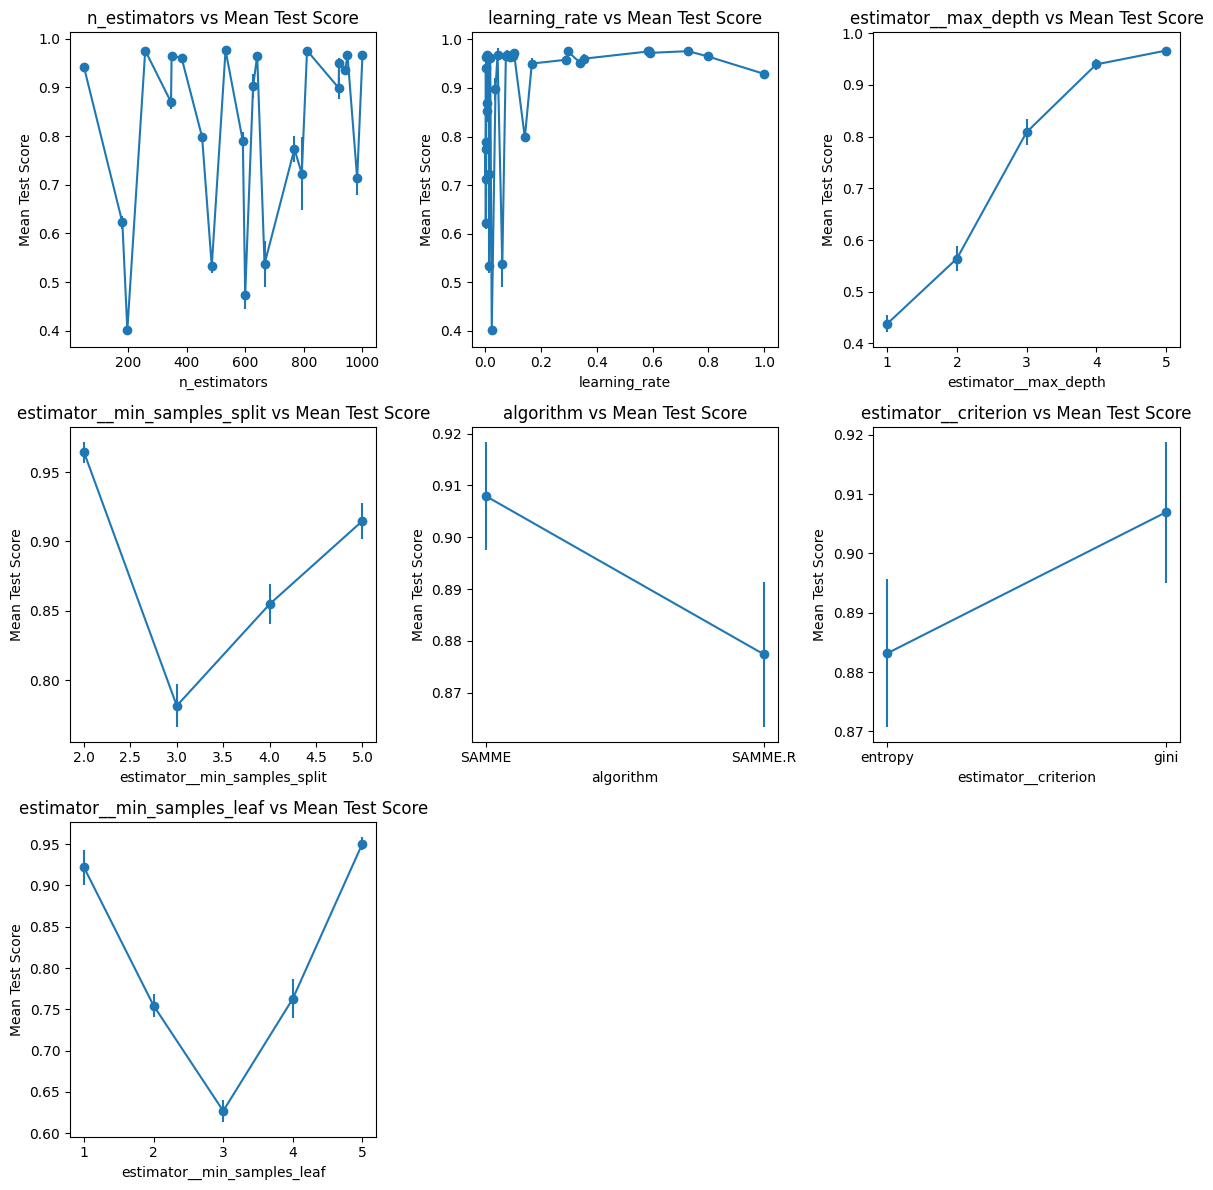

In [29]:
plot_yerr(abtree_model[0], abtree_parameters, n_rows=3)

- Το μοντέλο ταξινομεί σωστά τα 409 από τα 423 δεδομένα του test set 
- Παρατηρείται επίσης ισχυρή διαγώνιος
- 5/14 σφάλματα προέκυψαν με την πρόβλεψη κατηγορίας `Normal Weight`, ενώ η πραγματική κατηγορία είναι `Insufficient Weight`
- 10/14 σφάλματα προέρχονται από υπερεκτίμηση της αληθινής κατηγορίας κατά έναν βαθμό παχυσαρκίας

In [38]:
y_pred_abtree = abtree_model[0].predict(X_test[feature_set_0])
cm_abtree = confusion_matrix(y_test, y_pred_abtree)

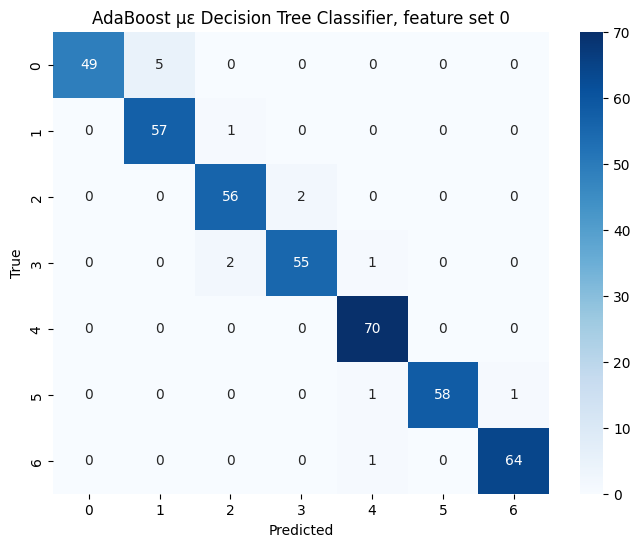

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_abtree, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.title('AdaBoost με Decision Tree Classifier, feature set 0')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## AdaBoost Classifier (logistic regression based)

### - **Το ακόλουθο κελί δεν χρειάζεται να τρέξει λόγω υπολογιστικού φόρτου**
### - Το εκπαιδευμένο σύνολο των Bayesian search είναι αποθηκευμένο ως ablr_dict.pkl και φορτώνεται στη συνέχεια

In [79]:
# ίδια διαδικασία με το προηγούμενο grid 

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_state=42

param_grid_ablr = {
    'estimator': [LogisticRegression(max_iter=100, multi_class='multinomial', random_state=random_state)],  # Using logistic regression as base estimator
    'estimator__C': Real(0.1, 1000, prior='log-uniform'),  # Αντίστροφo του regularization strength
    'estimator__solver': Categorical(['lbfgs', 'saga']),  # Αλγόριθμος Βελτιστοποίησης
    'n_estimators': Integer(50, 1000), 
    'learning_rate': Real(0.001, 1, prior='log-uniform'),
    'algorithm': Categorical(['SAMME', 'SAMME.R'])
}

ablr_bs_0 = BayesSearchCV(AdaBoostClassifier(random_state=random_state), param_grid_ablr, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
ablr_bs_1 = BayesSearchCV(AdaBoostClassifier(random_state=random_state), param_grid_ablr, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
ablr_bs_2 = BayesSearchCV(AdaBoostClassifier(random_state=random_state), param_grid_ablr, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
ablr_bs_3 = BayesSearchCV(AdaBoostClassifier(random_state=random_state), param_grid_ablr, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
ablr_bs_4 = BayesSearchCV(AdaBoostClassifier(random_state=random_state), param_grid_ablr, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
ablr_bs_5 = BayesSearchCV(AdaBoostClassifier(random_state=random_state), param_grid_ablr, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)
ablr_bs_6 = BayesSearchCV(AdaBoostClassifier(random_state=random_state), param_grid_ablr, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)

ablr_dict = {ablr_bs_0: feature_set_0,
           ablr_bs_1: feature_set_1,
           ablr_bs_2: feature_set_2,
           ablr_bs_3: feature_set_3,
           ablr_bs_4: feature_set_4,
           ablr_bs_5: feature_set_5,
           ablr_bs_6: feature_set_6}

%%time # Τοπικά χρειάστηκε περίπου 1 ώρα και 8 λεπτά
for i, (ablr_model, param_set) in enumerate(ablr_dict.items()):
    print(i)
    ablr_model.fit(X_train[param_set], y_train.squeeze())

In [82]:
# with open('ablr_dict.pkl', 'wb') as f:
#     pickle.dump(ablr_dict, f)

In [30]:
with open('ablr_dict.pkl', 'rb') as f:
    ablr_dict = pickle.load(f)

In [31]:
ablr_stats_dict = get_stats_dict(ablr_dict)
ablr_stats_df = pd.DataFrame(ablr_stats_dict).T

In [32]:
ablr_stats_df

,best_mean_test_score_cv,final_test_score,sens c_0,sens c_1,sens c_2,sens c_3,sens c_4,sens c_5,sens c_6,spec c_0,spec c_1,spec c_2,spec c_3,spec c_4,spec c_5,spec c_6,algorithm,estimator,estimator__C,estimator__solver,learning_rate,n_estimators
gs_0,0.938982,0.952719,0.981481,0.947368,0.927273,0.904762,1.0,0.921875,0.984615,0.99729,0.989071,0.980978,0.997222,0.986034,0.997214,0.997207,SAMME,"LogisticRegression(multi_class='multinomial', ...",1000.0,lbfgs,0.033716,50
gs_1,0.956165,0.959811,0.947368,0.963636,0.915254,0.931034,0.985507,0.983333,0.984615,1.0,0.986413,0.989011,0.989041,0.99435,0.997245,0.997207,SAMME,"LogisticRegression(multi_class='multinomial', ...",1000.0,lbfgs,0.081295,1000
gs_2,0.951427,0.964539,1.0,0.964912,0.912281,0.932203,0.985714,0.967213,0.984615,1.0,0.991803,0.983607,0.991758,0.997167,0.997238,0.997207,SAMME,"LogisticRegression(multi_class='multinomial', ...",1000.0,lbfgs,0.025754,50
gs_3,0.757709,0.754137,0.836735,0.634921,0.686275,0.673077,0.684932,0.782609,0.969697,0.965241,0.95,0.938172,0.938005,0.942857,0.983051,0.997199,SAMME,"LogisticRegression(multi_class='multinomial', ...",1000.0,lbfgs,0.001,464
gs_4,0.799761,0.763593,0.830189,0.678571,0.686275,0.634615,0.684211,0.826087,0.969697,0.972973,0.945504,0.938172,0.932615,0.948127,0.991525,0.997199,SAMME,"LogisticRegression(multi_class='multinomial', ...",1000.0,lbfgs,0.001,175
gs_5,0.939577,0.945626,0.931034,1.0,0.903226,0.948276,0.985294,0.918033,0.939394,1.0,0.978552,0.99446,0.991781,0.991549,0.98895,0.991597,SAMME,"LogisticRegression(multi_class='multinomial', ...",1000.0,lbfgs,0.001712,1000
gs_6,0.943126,0.933806,0.947368,0.981132,0.885246,0.910714,0.957143,0.918033,0.938462,1.0,0.983784,0.98895,0.980926,0.991501,0.98895,0.988827,SAMME,"LogisticRegression(multi_class='multinomial', ...",1000.0,lbfgs,0.002584,1000


- Καλύτερο μοντέλο και υποσύνολο χαρακτηριστικών
    - Το καλύτερο test accuracy (**96.45%**) παρατηρείται με το subset 2 δηλαδή αυτό που βασίζεται στο Mutual Information με threshold 0.1
    - Οι καλύτεροι υπερπαράμετροι για αυτό το feature set είναι, `algorithm` = SAMME, `estimator__C` = 1000, `estimator__solver` = lbfgs, `learning_rate` = 0.025754, `n_estimators` = 50
- Sensitivity και Specificity του subset 0
    - Έχει το καλύτερο (ή ίδιο με το καλύτερο) sensitivity στις κατηγορίες 0, 6
    - Έχει το καλύτερο (ή ίδιο με το καλύτερο) specificity στις κατηγορίες 0, 1, 4, 6
    - Επίσης έχει 100% sensitivity και 100% sensitivity specificity στην κατηγορία 0, δηλαδή η πρόβλεψη του μοντέλου ήταν κατηγορία 0, μόνο όταν η πραγματική κατηγορία ήταν 0.

In [33]:
ablr_model = {}

for i, key in enumerate(ablr_dict.keys()):
    ablr_model[i] = key
    
    
ablr_parameters = ['estimator__C', 'estimator__solver', 'n_estimators', 
                   'learning_rate','algorithm']

- Πολύ μικρές τιμές `estimator_C`, δηλαδή μεγάλες τιμές penalty των συντελεστών, προκαλούν underfitting, και συνεπώς και χαμηλό test score
- Ο αλγόριθμος βελτιστοποίησης lbfgs φαίνεται πολύ καλύτερος σε σχέση με τον αλγόριθμο saga.
- Ο αλγόριθμος ενίσχυσης των αδύναμων learner SAMME έχει πολύ καλύτερα αποτελέσματα από τον αλγόριθμο SAMME.R

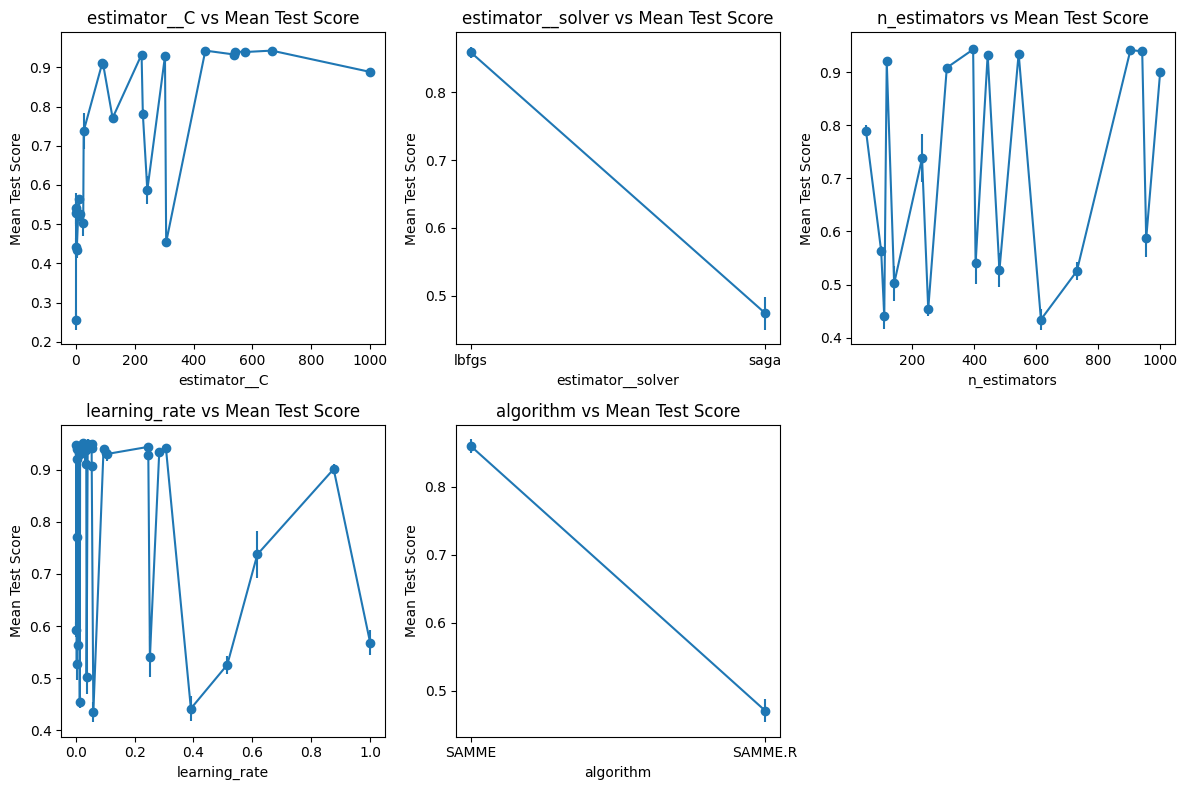

In [34]:
plot_yerr(ablr_model[2], ablr_parameters)

In [40]:
y_pred_ablr = ablr_model[2].predict(X_test[feature_set_2])
cm_ablr = confusion_matrix(y_test, y_pred_ablr)

- Το μοντέλο ταξινομεί σωστά τα 408 από τα 423 δεδομένα του test set 
- Παρατηρείται ισχυρή διαγώνιος
- Τα περισσότερα σφάλματα (11/15) προκύπτουν από τις κατηγορίες 1, 2 και 3. Η κατηγορία 1 υπερεκτιμάτε προς 2, η κατηγορία 2 είτε υποεκτιμάτε προς 1, είτε υπερεκτιμάτε προς 3 και η κατηγορία 3 υποεκτιμάτε προς 2.

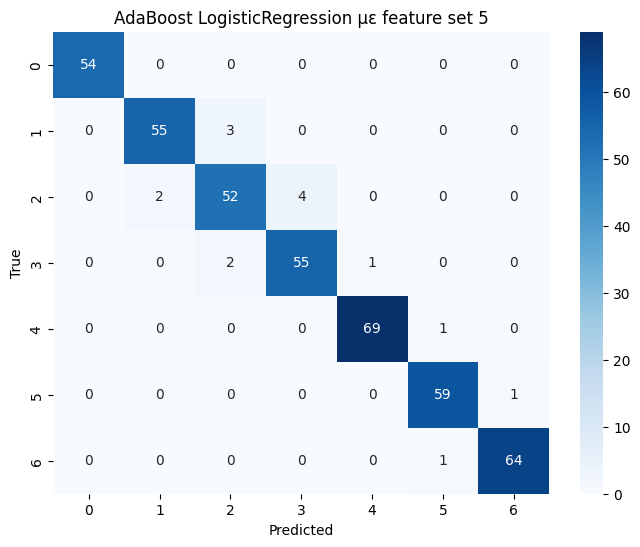

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ablr, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.title('AdaBoost LogisticRegression με feature set 5')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Gradient Boosting Classifier

### - **Το ακόλουθο κελί δεν χρειάζεται να τρέξει λόγω υπολογιστικού φόρτου**
### - Το εκπαιδευμένο σύνολο των Bayesian search είναι αποθηκευμένο ως gb_dict.pkl και φορτώνεται στη συνέχεια

In [89]:
# όμοια και για Gradient Boosting Classifier
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_space_gb = {
    'n_estimators': Integer(5, 300),         
    'learning_rate': Real(0.05, 0.5),              
    'max_depth': Integer(2, 15),                     
    'min_samples_split': Integer(2,10),              
    'min_samples_leaf': Integer(1, 10),              
}

gb_bs_0 = BayesSearchCV(GradientBoostingClassifier(random_state=random_state), param_space_gb, 
                        cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)

gb_bs_1 = BayesSearchCV(GradientBoostingClassifier(random_state=random_state), param_space_gb, cv=stratified_kfold,
                        scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state )

gb_bs_2 = BayesSearchCV(GradientBoostingClassifier(random_state=random_state), param_space_gb, cv=stratified_kfold,
                        scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)

gb_bs_3 = BayesSearchCV(GradientBoostingClassifier(random_state=random_state), param_space_gb, cv=stratified_kfold,
                        scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)

gb_bs_4 = BayesSearchCV(GradientBoostingClassifier(random_state=random_state), param_space_gb, cv=stratified_kfold,
                        scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)

gb_bs_5 = BayesSearchCV(GradientBoostingClassifier(random_state=random_state), param_space_gb, cv=stratified_kfold,
                        scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)

gb_bs_6 = BayesSearchCV(GradientBoostingClassifier(random_state=random_state), param_space_gb, cv=stratified_kfold,
                        scoring='accuracy', n_jobs=-1, verbose=0, random_state=random_state)

gb_dict = {gb_bs_0: feature_set_0,
           gb_bs_1: feature_set_1,
           gb_bs_2: feature_set_2,
           gb_bs_3: feature_set_3,
           gb_bs_4: feature_set_4,
           gb_bs_5: feature_set_5,
           gb_bs_6: feature_set_6}

%%time # Τοπικά χρειάστηκε 25.5 min

for i, (gb_model, param_set) in enumerate(gb_dict.items()):
    print(i)
    gb_model.fit(X_train[param_set], y_train.squeeze())

In [90]:
# with open('gb_dict.pkl', 'wb') as f:
#     pickle.dump(gb_dict, f)

In [42]:
with open('gb_dict.pkl', 'rb') as f:
    gb_dict = pickle.load(f)

In [43]:
gb_stats_dict = get_stats_dict(gb_dict)
gb_stats_df = pd.DataFrame(gb_stats_dict).T

In [44]:
gb_stats_df

,best_mean_test_score_cv,final_test_score,sens c_0,sens c_1,sens c_2,sens c_3,sens c_4,sens c_5,sens c_6,spec c_0,spec c_1,spec c_2,spec c_3,spec c_4,spec c_5,spec c_6,learning_rate,max_depth,min_samples_leaf,min_samples_split,n_estimators
gs_0,0.976897,0.952719,1.000000,0.918033,0.928571,0.913793,0.945205,0.967213,1.000000,0.989276,0.994475,0.983651,0.986301,0.997143,0.997238,0.997214,0.050000,7.0,7.0,2.0,175.0
gs_1,0.973933,0.957447,1.000000,0.890625,0.946429,0.947368,0.957746,0.967742,1.000000,0.986631,0.997214,0.986376,0.989071,0.994318,1.000000,0.997214,0.426825,13.0,4.0,10.0,260.0
gs_2,0.975714,0.962175,1.000000,0.906250,0.981481,0.947368,0.945205,0.967213,1.000000,0.989276,1.000000,0.986450,0.989071,0.997143,0.997238,0.997214,0.405883,7.0,6.0,8.0,279.0
gs_3,0.877966,0.888889,0.979167,0.793103,0.793103,0.857143,0.837500,0.983051,1.000000,0.981333,0.967123,0.967123,0.972752,0.991254,0.994505,0.997214,0.479965,11.0,9.0,5.0,117.0
gs_4,0.906400,0.888889,0.979167,0.739130,0.830189,0.839286,0.891892,0.982759,0.984615,0.981333,0.980226,0.962162,0.970027,0.988539,0.991781,0.997207,0.050000,15.0,10.0,10.0,300.0
gs_5,0.956760,0.966903,1.000000,0.919355,0.964912,0.949153,0.985294,0.967213,0.984848,0.989276,0.997230,0.991803,0.994505,0.991549,0.997238,1.000000,0.459373,6.0,9.0,3.0,21.0
gs_6,0.972751,0.959811,0.980392,0.904762,0.964286,0.964286,0.945205,0.982759,0.984848,0.989247,0.997222,0.989101,0.989101,0.997143,0.991781,1.000000,0.500000,4.0,6.0,10.0,300.0


- Καλύτερο μοντέλο και υποσύνολο χαρακτηριστικών.
    - Το καλύτερο test accuracy (**96.69%**) παρατηρείται με το subset 5 δηλαδή στο dataset `Weight` και `Height`.
    - Οι καλύτεροι υπερπαράμετροι για αυτό το feature subset είναι, `learning_rate` = 0.426825, `max_depth`= 6, `min_samples_leaf` = 9,  `min_samples_split` = 3, `n_estimators` = 21.
    - Παρατηρείται ότι το καλύτερο μοντέλο είναι αυτό με το πιο μικρό υποσύνολο χαρακτηριστικών και με πολύ απλές υπερπαραμέτρους. 
- Sensitivity και Specificity του subset 0.
    - Έχει το καλύτερο (ή ίδιο με το καλύτερο) sensitivity στις κατηγορίες 0, 1, 4.
    - Έχει το καλύτερο (ή ίδιο με το καλύτερο) specificity στις κατηγορίες 0, 2, 3, 6.

In [47]:
gb_model = {}

for i, key in enumerate(gb_dict.keys()):
    gb_model[i] = key
    
    
    
gb_parameters = ['n_estimators', 'learning_rate', 'max_depth', 
                   'min_samples_split','min_samples_leaf']

- Δεν παρατηρούνται εύκολα συγκεκριμένες περιοχές που να είναι καλύτερες από άλλες στο χώρο του search

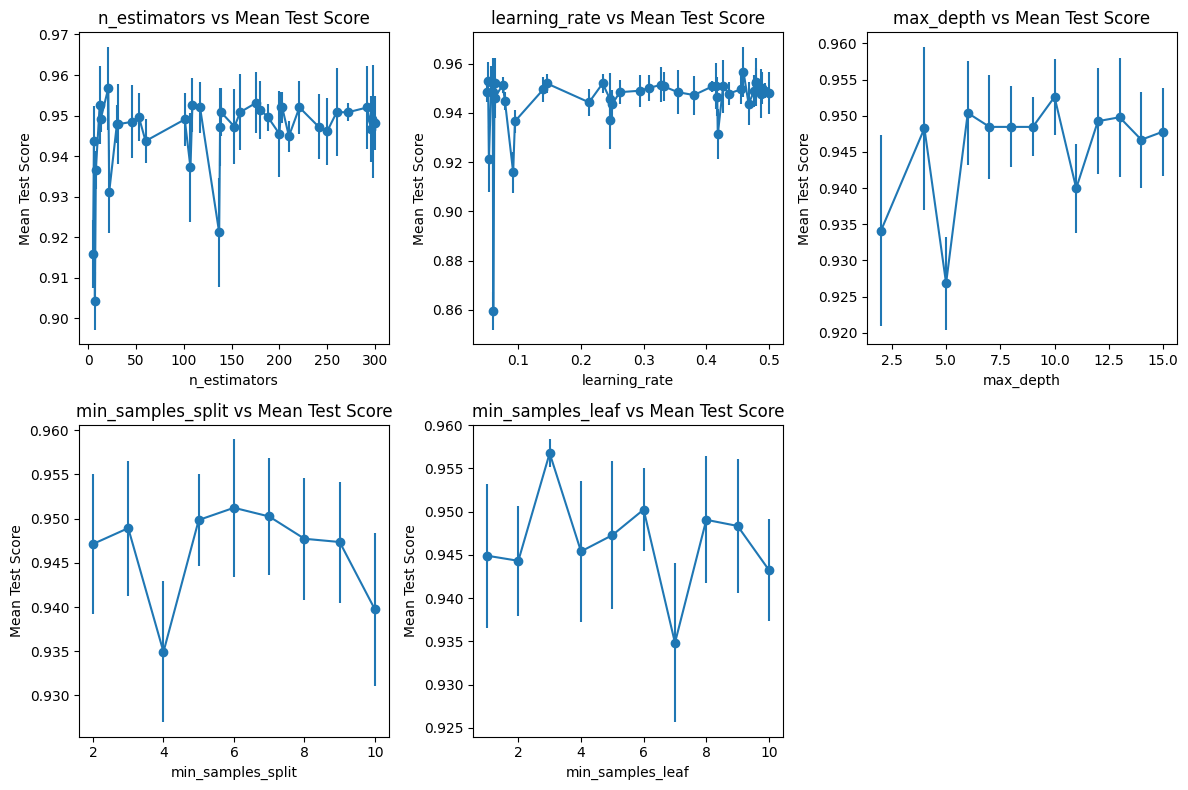

In [48]:
plot_yerr(gb_model[5], gb_parameters)

In [49]:
y_pred_gb = gb_model[5].predict(X_test[feature_set_5])
cm_gb = confusion_matrix(y_test, y_pred_gb)

- Το μοντέλο ταξινομεί σωστά τα 409 από τα 423 δεδομένα του test set 
- Παρατηρείται και σε αυτή την περίπτωση ισχυρή διαγώνιος
- 4/14 σφάλματα προέκυψαν με την πρόβλεψη κατηγορίας `Normal Weight`, ενώ η πραγματική κατηγορία είναι `Insufficient Weight`
- 11/14 σφάλματα προέρχονται από υπερεκτίμηση της αληθινής κατηγορίας κατά έναν βαθμό παχυσαρκίας

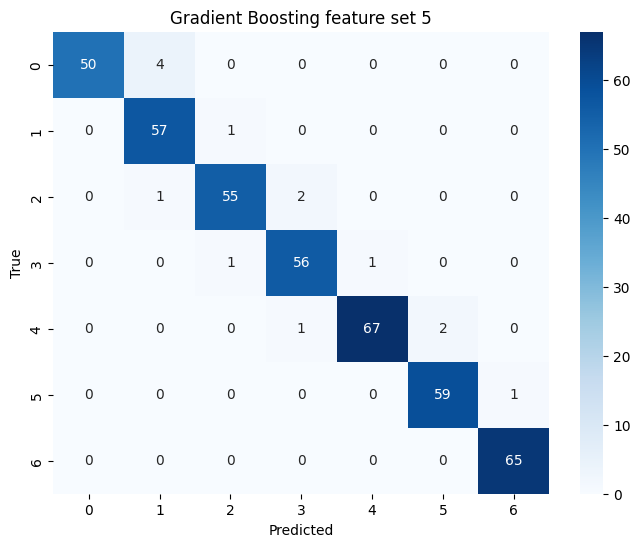

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.title('Gradient Boosting feature set 5')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()